To accomplish this task, we'll follow these general steps:

# Importing Packages

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sum
import torch
import torch.nn as nn
import xgboost as xgb
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, pacf

In [2]:
warnings.filterwarnings("ignore")

## Data Fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - and Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a fiven day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionDistanceOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Month]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Data Collection

We need historical data on store sales and promotion events. This data should include features like date, sales, promotion indicators, and possibly other relevant factors like holidays, special events, or weather conditions.

In [3]:
if not any((
    os.path.isfile(f"data/{f}.csv")
    for f in ("train", "test", "store")
)):
    !kaggle competitions download -c rossmann-store-sales -p data
    !unzip data/rossmann-store-sales.zip -d data
    !rm data/rossmann-store-sales.zip
else:
    print("Datal already exists!")

Datal already exists!


## store.csv

Supplemental information about the stores

### Load the Store Information Data

In [4]:
stores_df = pd.read_csv("data/store.csv")
stores_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


### Understand the Store Information Data

In [5]:
stores_df.shape

(1115, 10)

In [6]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


### Summary Information Statistics

In [7]:
stores_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [8]:
stores_df.describe(include="O")

,StoreType,Assortment,PromoInterval
count,1115,1115,571
unique,4,3,3
top,a,a,"Jan,Apr,Jul,Oct"
freq,602,593,335


### Data Visualization

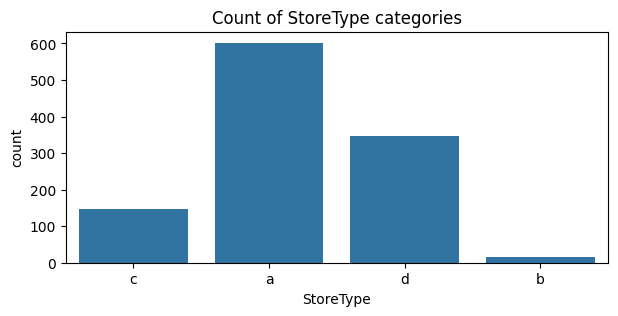

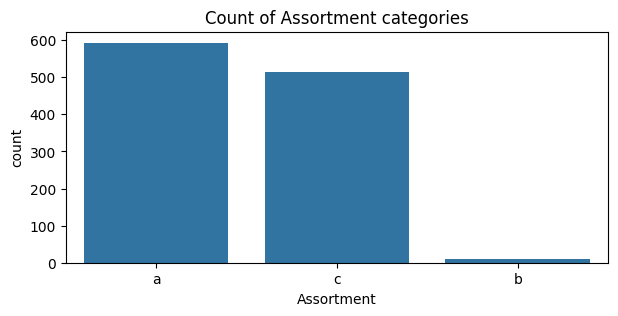

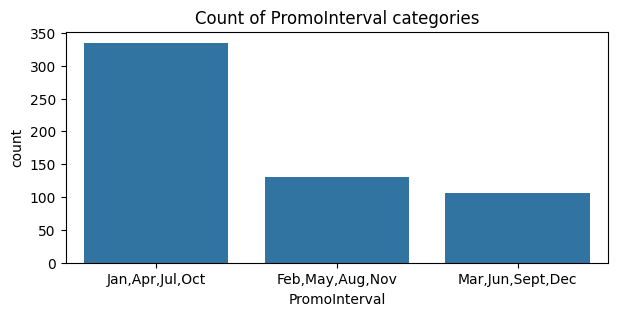

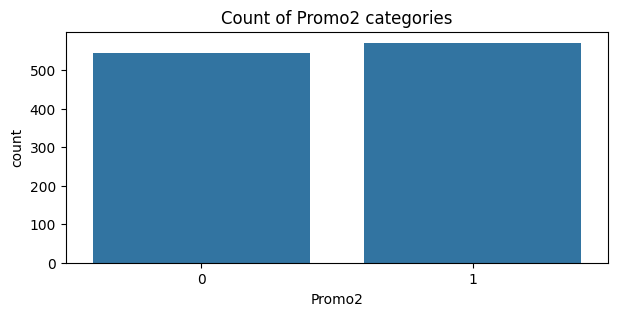

In [9]:
stores_category_fields = (
    "StoreType",
    "Assortment",
    "PromoInterval",
    "Promo2"
)

for col in stores_category_fields:
    fig = plt.figure(figsize=(7, 3))
    ax = sns.countplot(data=stores_df, x=col)
    ax.set_title(f"Count of {col} categories")

For **StoreType**:
- Types **a** and **d** are the most present.
- Types **b** is the less present, with way lower than **c**, the third one.

For **Assortments**:
- **a** and **c** are, by far, the most present ones.
- **b** is insignificant.

For **PromoInterval**:
- There are 3 types of cycles.
- Each cycle is 1 month shifted with relation to the other.
- Cycle `Jan,Apr,Jul,Oct` represents more than the half of the data.

For **Promo2**:
- Almost half of the stores participate in the consecutive promotion.

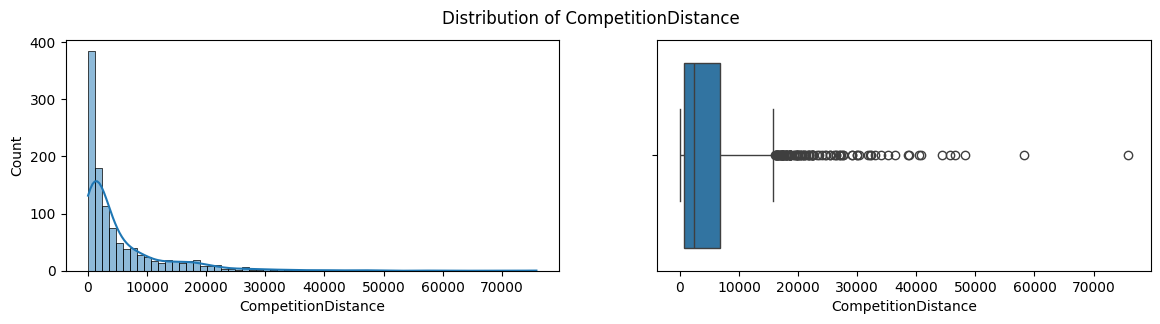

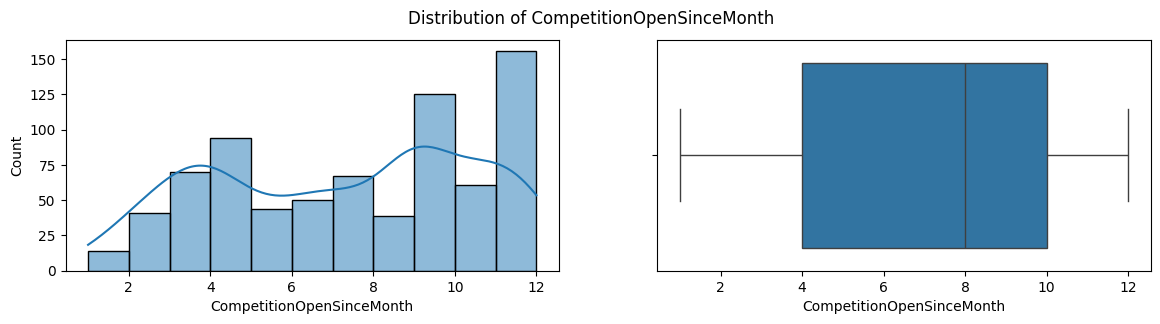

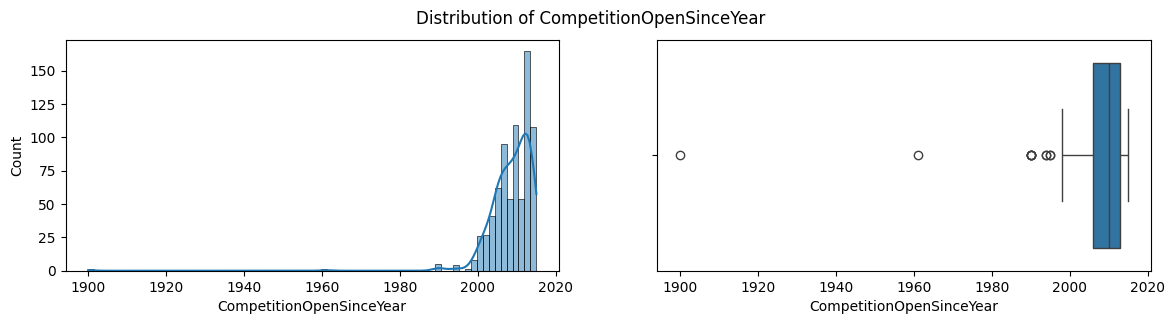

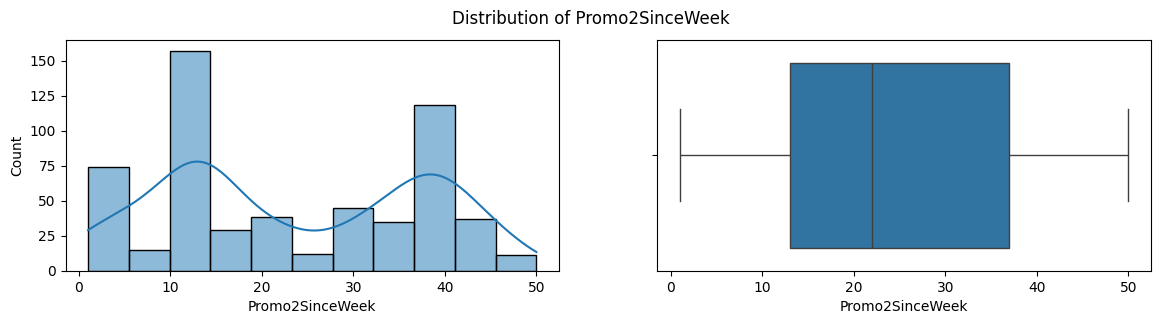

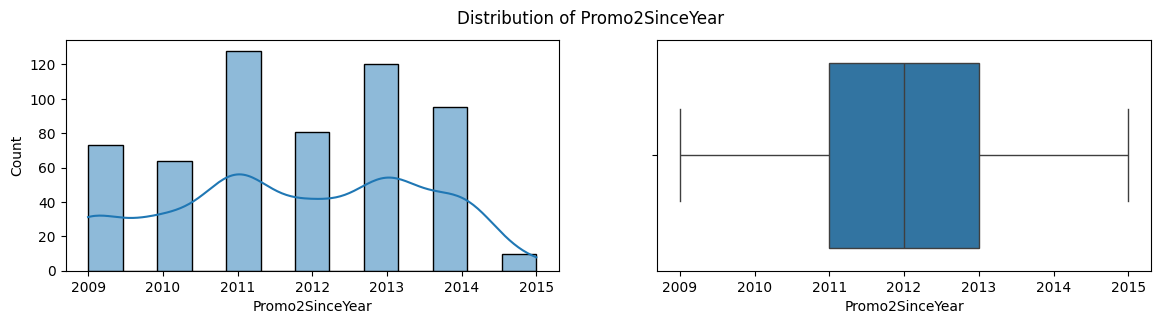

In [10]:
stores_numeric_cols = [
    "CompetitionDistance",
    "CompetitionOpenSinceMonth",
    "CompetitionOpenSinceYear",
    "Promo2SinceWeek",
    "Promo2SinceYear"
]

for col in stores_numeric_cols:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 3))
    fig.suptitle(f"Distribution of {col}")
    sns.histplot(data=stores_df, x=col, kde=True, ax=ax1)
    sns.boxplot(data=stores_df, x=col, ax=ax2)

For **CompetitionDistance**:
- There's a high positive skewness in the distribution, with the long right tail indicating  strong presence of outliers.
- Most of the data values is in between [0, 15000] meters.
- The median value is 2325 meters.

For **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear**:
- **CompetitionOpenSinceMonth** only makes sense whem combined with **CompetitionOpenSinceYear**, but even then, **CompetitionOpenSinceYear** has more information.
- Much of the competitions seems to have been opened in mid 2010s.
- The majority of the competition was opened between 2006 and 2013.
- The oldes competition open year is 1900, but, given the number o occorences of this value, it seems that this value is just a placeholder for the cases where the open year is unknow.

For **Promo2SinceWeek** and **Promo2SinceYear**:
- As with the last features, **Promo2SinceWeek** only makes sense when combined with **Promo2SinceYear**, but **Promo2SinceYear** alone has more information.
- The consecutive promotion has been adopted between years 2009 to 2015.
- 2011 and 2013 were the years with most adoptions of the consecutive promotion.

### Missing Values

In [11]:
stores_df.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

- The missing values in **CompetitionDistance**, **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear** may indicate that there isn't a tracked competition in the nearby store.
- The missing values in **Promo2SinceWeek**, **Promo2SinceYear** and **PromoInterval** may be related to stores that don't adopt the consecutive promotion.

As we're interested only in dealing with the time series approaches, we'll not consider these columns in our analysis, as they don't have a direct relation with the sales data and can be considered external factors.

## train.csv

Historical data including Sales

### Load the Sales Data

In [12]:
sales_df = pd.read_csv("data/train.csv")
sales_df["Date"] = pd.to_datetime(sales_df["Date"])
sales_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [13]:
sales_df["DayOfWeek"] = sales_df["Date"].dt.day_name()
sales_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,Friday,2015-07-31,5263,555,1,1,0,1
1,2,Friday,2015-07-31,6064,625,1,1,0,1
2,3,Friday,2015-07-31,8314,821,1,1,0,1
3,4,Friday,2015-07-31,13995,1498,1,1,0,1
4,5,Friday,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,Tuesday,2013-01-01,0,0,0,0,a,1
1017205,1112,Tuesday,2013-01-01,0,0,0,0,a,1
1017206,1113,Tuesday,2013-01-01,0,0,0,0,a,1
1017207,1114,Tuesday,2013-01-01,0,0,0,0,a,1


### Understand the Sales Data

In [14]:
sales_df.shape

(1017209, 9)

In [15]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  object        
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 69.8+ MB


### Summary Statistics

In [16]:
sales_df[["Sales", "Customers"]].describe()

,Sales,Customers
count,1.017209e+06,1.017209e+06
mean,5.773819e+03,6.331459e+02
std,3.849926e+03,4.644117e+02
min,0.000000e+00,0.000000e+00
25%,3.727000e+03,4.050000e+02
50%,5.744000e+03,6.090000e+02
75%,7.856000e+03,8.370000e+02
max,4.155100e+04,7.388000e+03


- The minimum value of 0.0 in both **Sales** and **Customers** indicates days which stores didn't have any sales. These values may indicate days when the stores were closed.
- 50% of the sales data is in between [3727 - 7856]. The high variation to the max value of 41551 may indicate the presence of outliers.
- 50% of the customers numbers data is in between [405 - 837]. The high variation to the max value of 7.388 may indicate the presence of outliers.

### Data Visualization

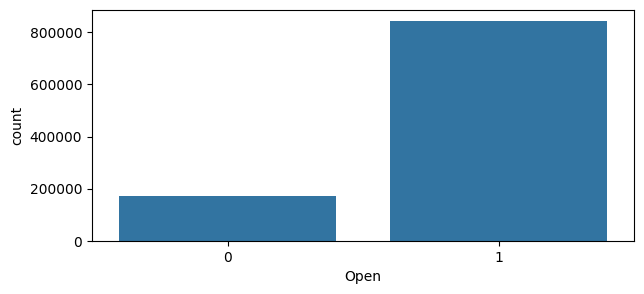

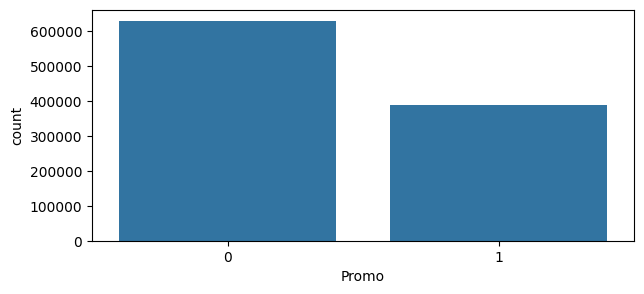

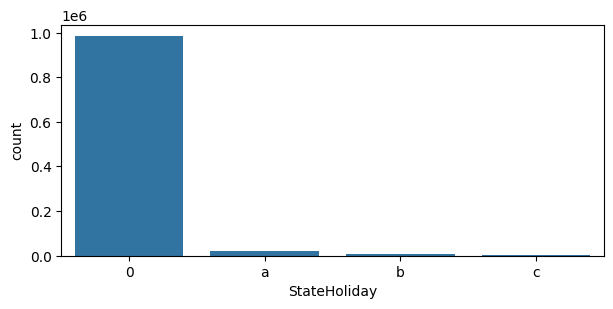

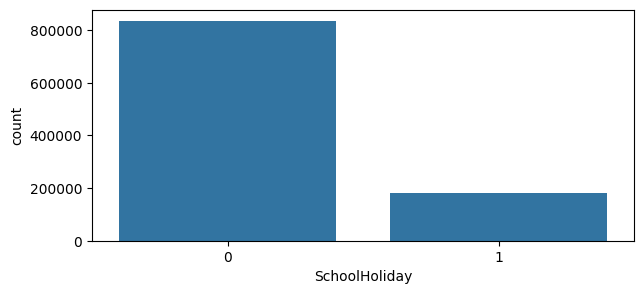

In [17]:
sales_category_fields = [
    "Open",
    "Promo",
    "StateHoliday",
    "SchoolHoliday"
]

for col in sales_category_fields:
    plt.figure(figsize=(7, 3))
    sns.countplot(data=sales_df, x=col)

- **StateHoliday** and **SchoolHoliday** are self explanatory. The overwhelming majority of data for non state holidays. WE have a higher number of school holidays, but this makes sense, as schools usually don't open at weekends.
- Almost 40% of the data corresponds to days with promotion.
- We also have almost 20% of data corresponding to days with stores closed. Maybe, like in **SchoolHoliday**, this is related to weekends.

In [18]:
sales_opened_stores_df = sales_df[sales_df["Open"] == 1]

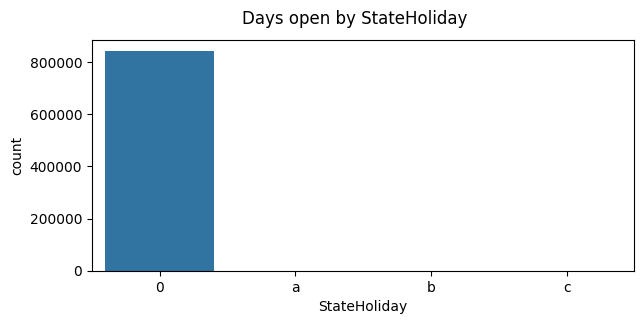

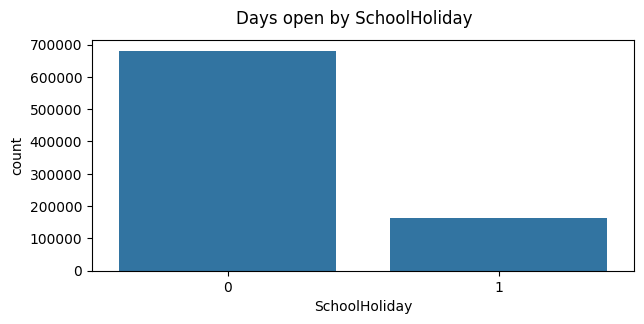

In [19]:
for col in ("StateHoliday", "SchoolHoliday"):
    fig = plt.figure(figsize=(7, 3))
    sns.countplot(data=sales_opened_stores_df, x=col)
    fig.suptitle(f"Days open by {col}")

- Generally speaking, stores don't open in state holidays with few exceptions.
- Also, stores generally don't open in school holidays, but this time the days when they open at these holidays is significantly higher.

In [22]:
sales_df.DayOfWeek.unique()

array(['Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday', 'Sunday',
       'Saturday'], dtype=object)

Text(0.5, 0.98, 'Days open by SchoolHoliday')

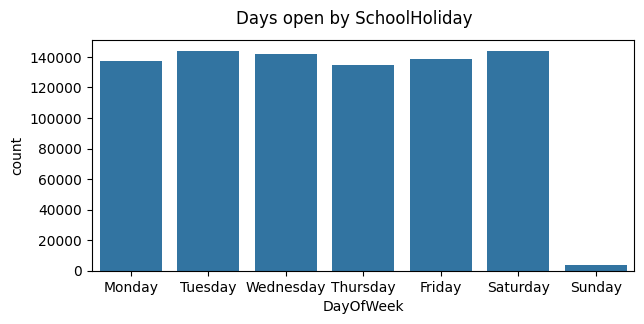

In [23]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

fig = plt.figure(figsize=(7, 3))
sns.countplot(data=sales_opened_stores_df, x="DayOfWeek", order=order)
fig.suptitle(f"Days open by {col}")

- Stores generally don't open in Sundays.

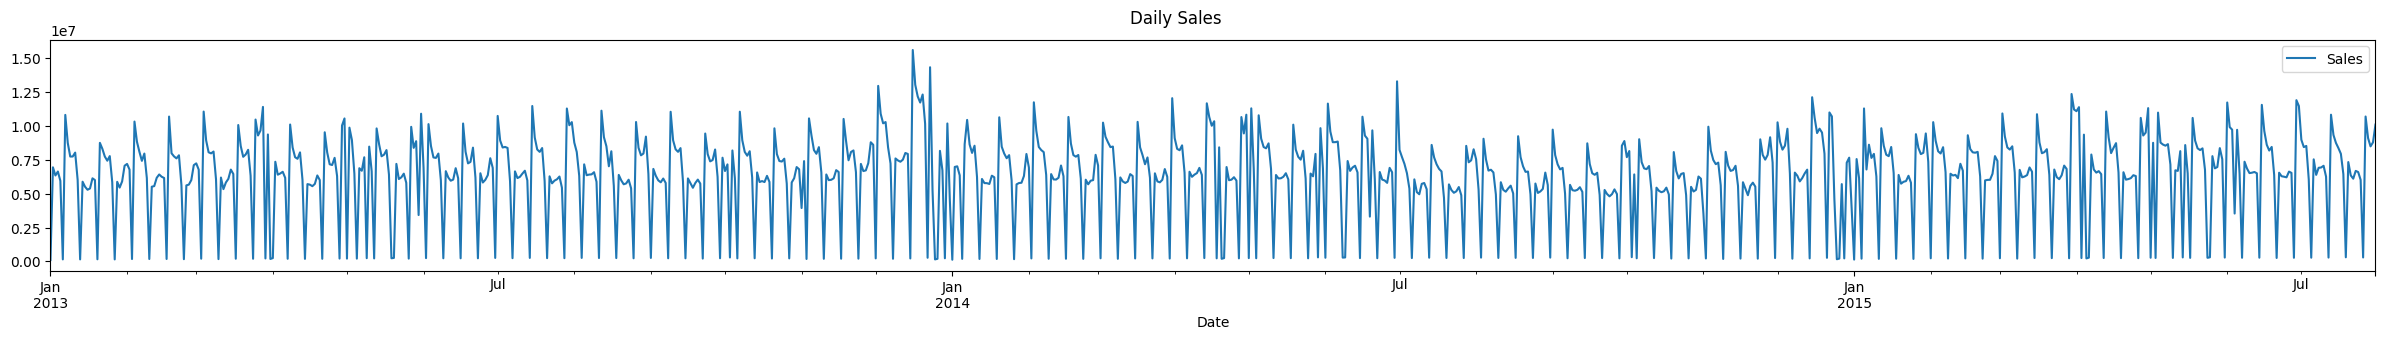

In [38]:
total_sales_opened_df = sales_opened_stores_df.groupby("Date")[["Sales"]].sum()

fig, ax = plt.subplots(figsize=(30, 3))
fig.suptitle("Daily Sales")
total_sales_opened_df.plot(kind="line", ax=ax);

We can see some kind of periodic pattern. Better to take a closer look.

<Axes: xlabel='Date'>

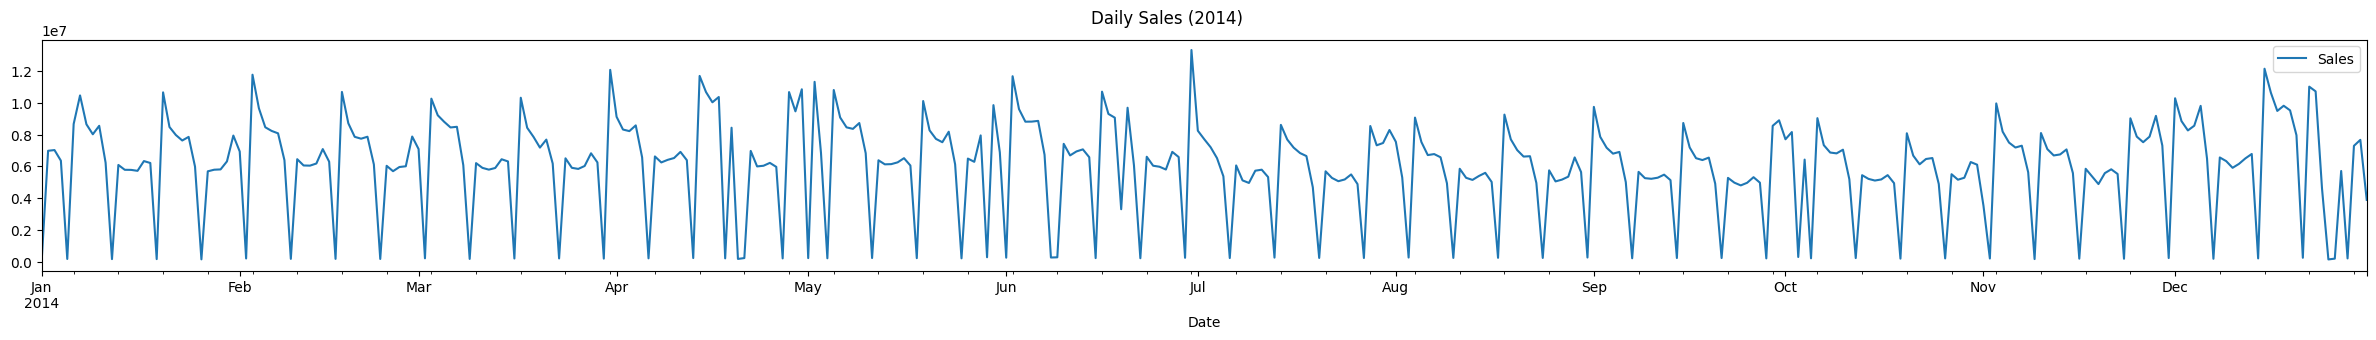

In [39]:
total_2014_sales_opened_df = total_sales_opened_df[
    (total_sales_opened_df.index >= "2014-01-01") & (total_sales_opened_df.index < "2015-01-01")
]

fig, ax = plt.subplots(figsize=(30, 3))
fig.suptitle("Daily Sales (2014)")
total_2014_sales_opened_df.plot(kind="line", ax=ax)

We still see a periodic pattern, but it's not clear yet.

# Data Preprocessing

This step involves cleaning and preparing the data for analysis. It may include handling missing values, encoding categorical variables, and scaling numerical features.

Join the sales data with stores information and keep only relevant features.

In [43]:
sales_df["DayOfWeek"] = sales_df["Date"].dt.day_of_week
sales_df["Month"] = sales_df["Date"].dt.month
sales_df["Year"] = sales_df["Date"].dt.year

sales_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year
0,1,4,2015-07-31,5263,555,1,1,0,1,7,2015
1,2,4,2015-07-31,6064,625,1,1,0,1,7,2015
2,3,4,2015-07-31,8314,821,1,1,0,1,7,2015
3,4,4,2015-07-31,13995,1498,1,1,0,1,7,2015
4,5,4,2015-07-31,4822,559,1,1,0,1,7,2015
...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,a,1,1,2013
1017205,1112,1,2013-01-01,0,0,0,0,a,1,1,2013
1017206,1113,1,2013-01-01,0,0,0,0,a,1,1,2013
1017207,1114,1,2013-01-01,0,0,0,0,a,1,1,2013


In [45]:
stores_df = stores_df[["Store", "StoreType", "Promo2"]]
stores_df

,Store,StoreType,Promo2
0,1,c,0
1,2,a,1
2,3,a,1
3,4,c,0
4,5,a,0
...,...,...,...
1110,1111,a,1
1111,1112,c,0
1112,1113,a,0
1113,1114,a,0


In [47]:
joined_sales_stores_df = sales_df.merge(stores_df, on="Store").set_index("Date")
joined_sales_stores_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,StoreType,Promo2
Date,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,7,2015,c,0
2015-07-30,1,3,5020,546,1,1,0,1,7,2015,c,0
2015-07-29,1,2,4782,523,1,1,0,1,7,2015,c,0
2015-07-28,1,1,5011,560,1,1,0,1,7,2015,c,0
2015-07-27,1,0,6102,612,1,1,0,1,7,2015,c,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-05,1115,5,4771,339,1,0,0,1,1,2013,d,1
2013-01-04,1115,4,4540,326,1,0,0,1,1,2013,d,1
2013-01-03,1115,3,4297,300,1,0,0,1,1,2013,d,1


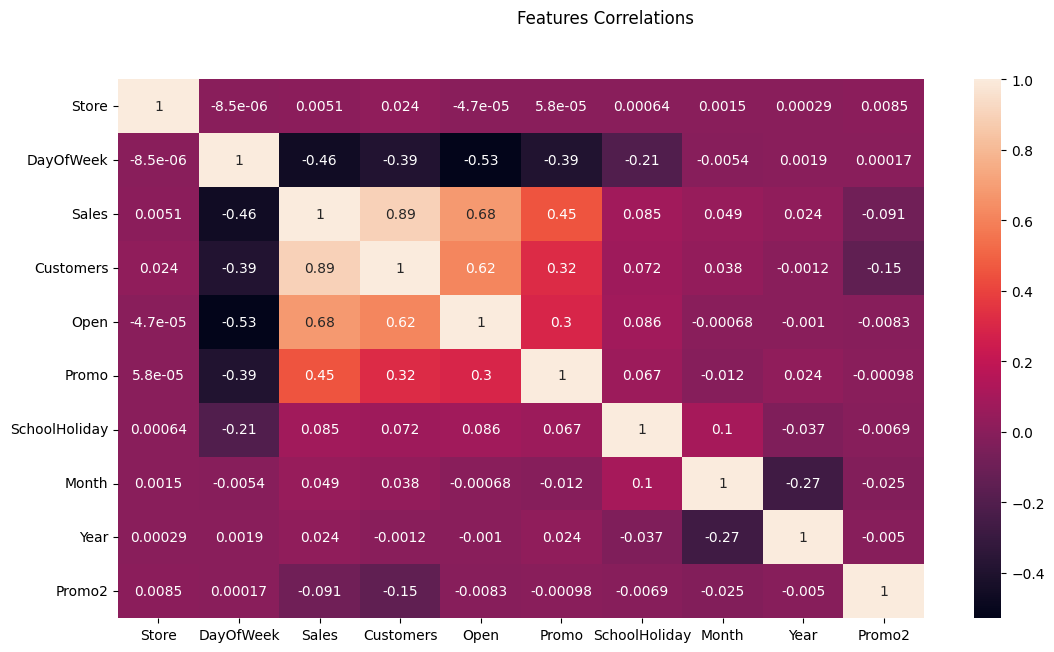

In [58]:
corr = joined_sales_stores_df.select_dtypes(["int", "float"]).corr()

fig = plt.figure(figsize=(13, 7))
fig.suptitle("Features Correlations")
sns.heatmap(corr, annot=True);

- The **Sales** is high correlated with the **DayOfWeek**, **Customers**, **Open** and **Promo**, and it makes perfectly sense.
- **Promo2** doesn't affect **Sales** at all.

In [59]:
joined_sales_stores_df = joined_sales_stores_df[
    (joined_sales_stores_df["Open"] == 1) & joined_sales_stores_df["Sales"] > 0
]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,StoreType,Promo2
Date,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,7,2015,c,0
2015-07-28,1,1,5011,560,1,1,0,1,7,2015,c,0
2015-07-23,1,3,3769,503,1,0,0,0,7,2015,c,0
2015-07-20,1,0,4395,526,1,0,0,0,7,2015,c,0
2015-07-16,1,3,4427,517,1,1,0,0,7,2015,c,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-08,1115,1,5243,341,1,1,0,1,1,2013,d,1
2013-01-07,1115,0,6905,471,1,1,0,1,1,2013,d,1
2013-01-05,1115,5,4771,339,1,0,0,1,1,2013,d,1


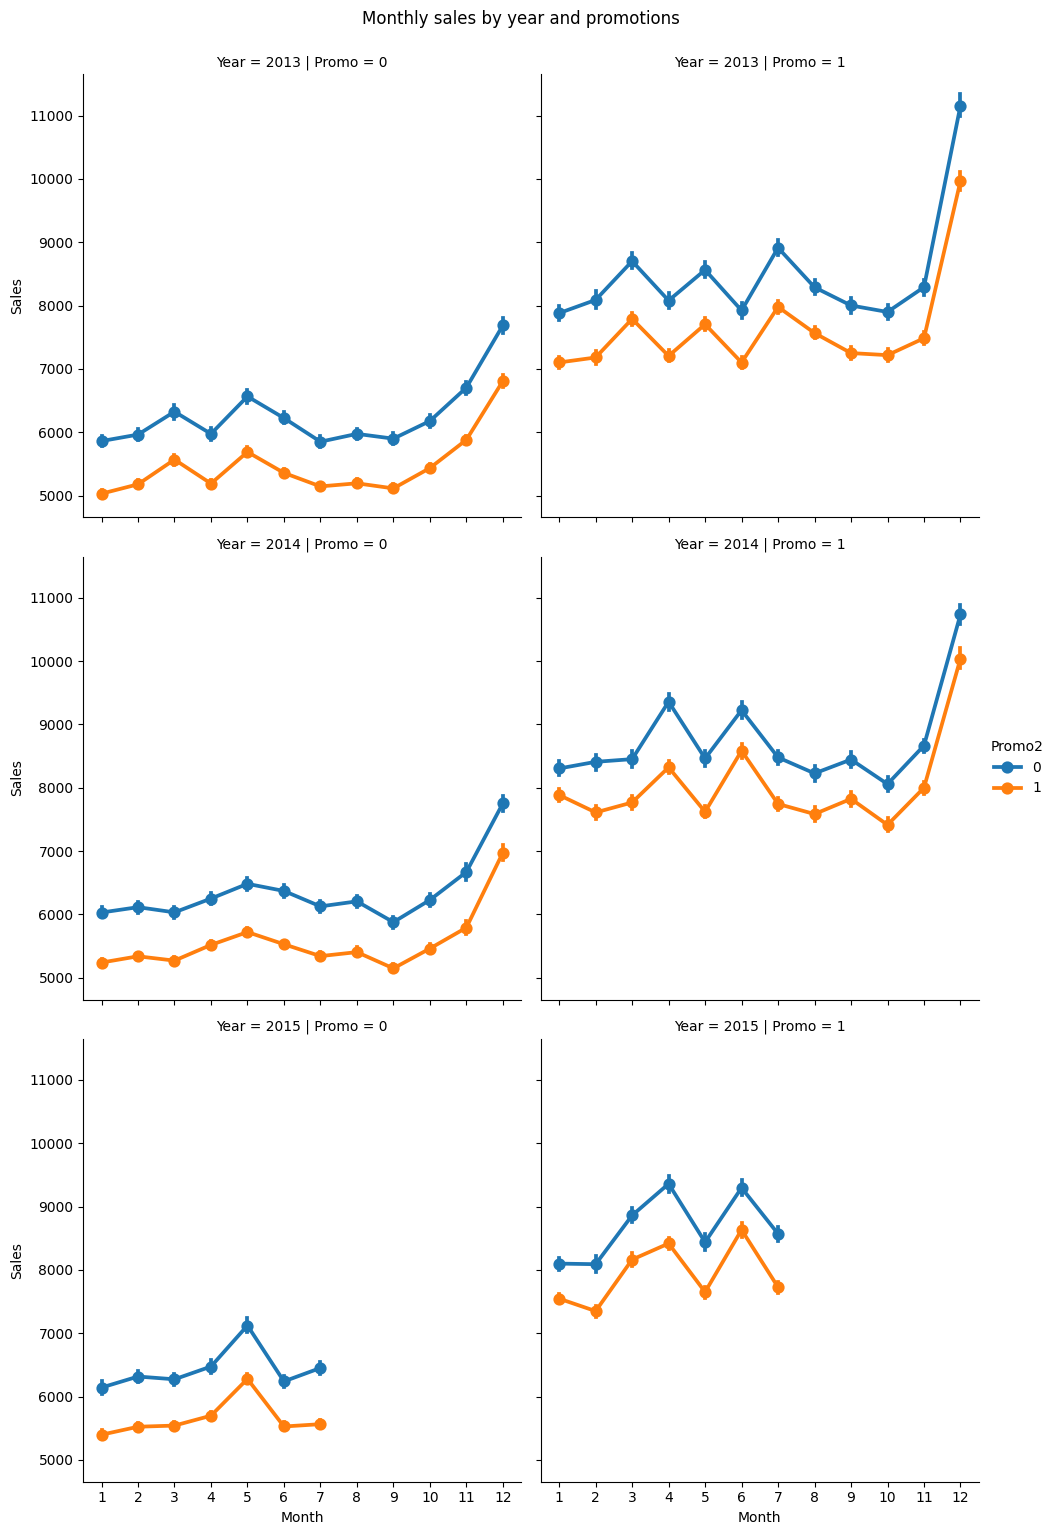

In [78]:
g = sns.catplot(
    data=joined_sales_stores_df,
    x="Month",
    y="Sales",
    kind="point",
    col="Promo",
    hue="Promo2",
    row="Year"
)
g.fig.suptitle("Monthly sales by year and promotions", y=1.02);

- Sales tend to go up in the end of the year (Christmas).
- **Promo2** indeed don't affect **Sales**.

In [84]:
joined_sales_stores_df["DayName"] = joined_sales_stores_df.index.day_name()

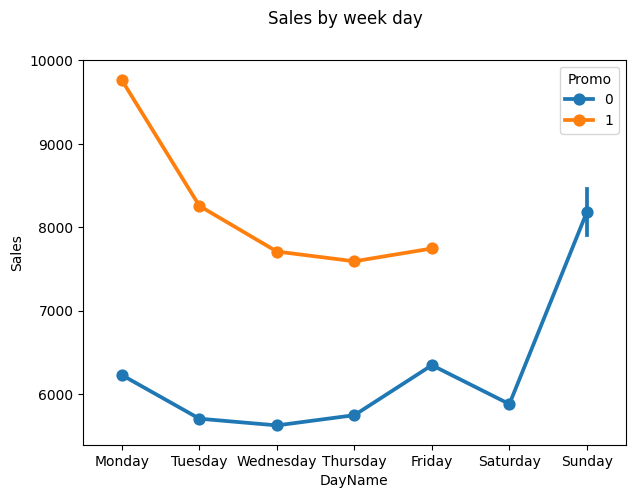

In [93]:
fig = plt.figure(figsize=(7, 5))
sns.pointplot(data=joined_sales_stores_df, x="DayName", y="Sales", hue="Promo", order=order)
fig.suptitle("Sales by week day");

- There are no promotions on Saturdays and Sundays.
- Promotions are actually effective.
- Maximum sales on Mondays.

# Feature Engineering

Creating additional relevant features from the existing data, such as lagged sales, rolling statistics, or any other variables that might impact sales.

# Model Selection

Choosing an appropriate machine learning model for time series forecasting. Common models for time series forecasting include ARIMA, Prophet, and various machine learning algorithms such as Random Forest, XGBoost, or LSTM (Long Short-Term Memory).

# Model Training

Using historical data to train the selected model. We will use a portion of the data for training and hold out another portion for evaluation.

# Model Evaluation

Assessing the model's performance using evaluation metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE).

# Hyperparameter Tuning

Fine-tuning the model's hyperparameters to improve its performance.

# Forecasting

Using the trained model to make sales forecasts for future weeks, considering promotion indicators.

# Visualization and Interpolation

Visualizing the forecasted sales and interpreting the results. This may include identifying the impact of promotions on sales.

# Deployment

If necessary, deploying the model in a production environment for ongoing sales forecasting.